## 1. Imports


In [1]:
import sys
import gc

import torch
from torch.utils.data import Subset
import torchvision.datasets as datasets
import numpy as np
from diffusers import DDIMScheduler
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

sys.path.append("..")
from utils import (
    set_random_seed,
    get_all_pivotal,
    cod_prob_bound,
    estimate_cod_prob_bound,
)

%matplotlib inline 

## 2. Config


In [2]:
SEED = 0x3060
set_random_seed(SEED)

# dataset choosing
DATASET, DATASET_PATH = "fmnist2mnist", "./data/"

IMG_SIZE = 28

# the step number adding noise in diffusion process
DIFFUSION_STEPS = 1000
PIVOTAL_LIST = [20, 50, 100]

# All hyperparameters below is set to the values used for the experiments, which discribed in the article
EPSILON = 0.3
R = 1000
N = 2
P = 1


# data sample settings
SUBSET_CLASS = 3

# plot settings
GRAY_PLOTS = True

## 3. Initialize samplers


In [3]:
source_transform = Compose(
    [
        Resize((IMG_SIZE, IMG_SIZE)),
        ToTensor(),
        Normalize((0.5), (0.5)),
    ]
)
target_transform = source_transform

if DATASET == "fmnist2mnist":
    source = datasets.FashionMNIST
    target = datasets.MNIST

elif DATASET == "mnist2fmnist":
    source = datasets.MNIST
    target = datasets.FashionMNIST

elif DATASET == "mnist2usps":
    source = datasets.MNIST
    target = datasets.USPS

elif DATASET == "usps2mnist":
    source = datasets.USPS
    target = datasets.MNIST

elif DATASET == "usps2fmnist":
    source = datasets.USPS
    target = datasets.FashionMNIST

elif DATASET == "fmnist2usps":
    source = datasets.FashionMNIST
    target = datasets.USPS
else:
    raise Exception(f"{DATASET} not support now...")

In [4]:
source_dataset = source(
    root=DATASET_PATH, train=True, download=True, transform=source_transform
)
target_dataset = target(
    root=DATASET_PATH, train=True, download=True, transform=target_transform
)

source_indices = [
    i for i, label in enumerate(source_dataset.targets) if label == SUBSET_CLASS
]
target_indices = [
    i for i, label in enumerate(target_dataset.targets) if label == SUBSET_CLASS
]
source_indices = source_indices[: min(len(source_indices), len(target_indices))]
target_indices = target_indices[: min(len(source_indices), len(target_indices))]


source_dataset = Subset(source_dataset, source_indices)
target_dataset = Subset(target_dataset, target_indices)

len(source_dataset), len(target_dataset)

(6000, 6000)

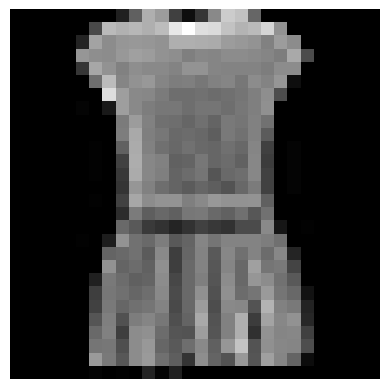

In [5]:
def plot_data_point(x):
    plt.imshow(x.numpy(), cmap="gray")
    plt.axis("off")  # 不显示坐标轴
    plt.show()


plot_data_point(source_dataset[0][0].squeeze(0))

### noise adder


In [6]:
SCHEDULER = DDIMScheduler(num_train_timesteps=DIFFUSION_STEPS)


def sample_all_pivotal(X, Y) -> list[torch.Tensor]:
    return get_all_pivotal(
        X,
        Y,
        SCHEDULER,
        PIVOTAL_LIST,
    )

In [7]:
def plot_all_pivotal(
    source: torch.Tensor,
    target: torch.Tensor,
    gray: bool = False,
):
    pivotal_path = sample_all_pivotal(source, target)

    imgs: np.ndarray = (
        torch.stack(pivotal_path)
        .to("cpu")
        .permute(0, 2, 3, 1)
        .mul(0.5)
        .add(0.5)
        .numpy()
        .clip(0, 1)
    )
    nrows, ncols = 1, len(pivotal_path)
    fig = plt.figure(figsize=(1.5 * ncols, 1.5 * nrows), dpi=150)
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(nrows, ncols, i + 1)
        if gray:
            ax.imshow(img, cmap="gray")
        else:
            ax.imshow(img)
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_title(f"$X_{i}$", fontsize=24)
        if i == imgs.shape[0] - 1:
            ax.set_title("Y", fontsize=24)

    torch.cuda.empty_cache()
    gc.collect()

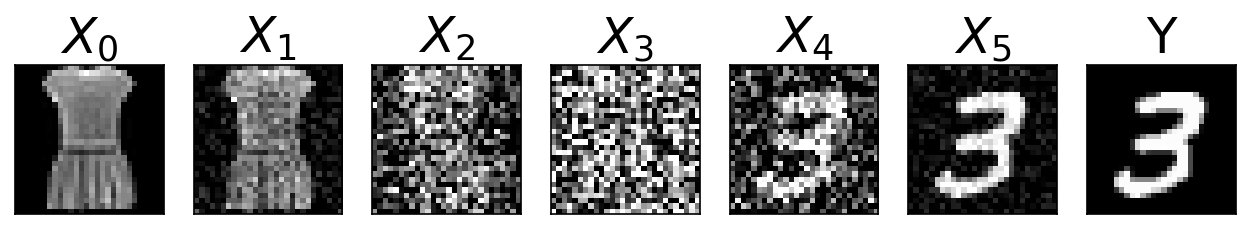

In [8]:
plot_all_pivotal(
    source_dataset[0][0],
    target_dataset[0][0],
    gray=GRAY_PLOTS,
)

## 4. Concentration of Distance Probability


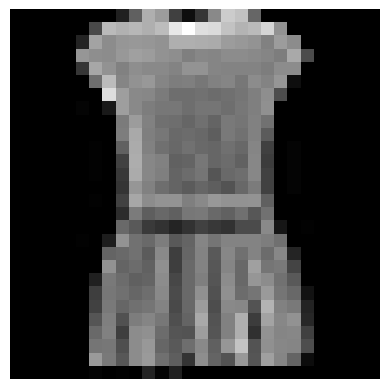

In [9]:
Q_point = source_dataset[0][0]
plot_data_point(Q_point.squeeze())

In [10]:
prob_bound = cod_prob_bound(
    target_dataset,
    EPSILON,
    Q_point,
    "euclidean",
    N,
)

print(f"P{{DMAX({N})<=(1+{EPSILON})DMIN({N})}}>={prob_bound:.4%}")

n=2 p=1 epsilon=0.3 distance_type='euclidean'
RV=np.float32(0.002350549)
prob_bound=np.float64(0.7427681069196088)
P{DMAX(2)<=(1+0.3)DMIN(2)}>=74.2768%


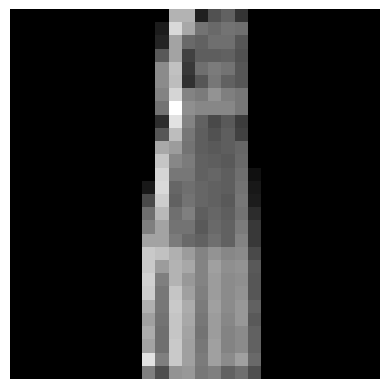

n=2 r=1000 p=1 epsilon=0.3 distance_type='euclidean'
RV=np.float32(0.011053575)
prob_bound=np.float64(0.12200773947578952)
P{DMAX(2)<=(1+0.3)DMIN(2)}>=12.2008%


In [11]:
Q_point = source_dataset[666][0]
plot_data_point(Q_point.squeeze())

estimate_prob_bound = estimate_cod_prob_bound(
    target_dataset,
    EPSILON,
    R,
    Q_point,
    "euclidean",
    N,
)

print(f"P{{DMAX({N})<=(1+{EPSILON})DMIN({N})}}>={estimate_prob_bound:.4%}")

### TODO:asymptotic distribution prob bound


In [12]:
path_list = []
for (x, _), (y, _) in tqdm(zip(source_dataset, target_dataset)):
    path = get_all_pivotal(x, y, SCHEDULER, PIVOTAL_LIST)
    path = torch.stack(path)
    path_list.append(path)

path_list = torch.stack(path_list).transpose(0, 1)

0it [00:00, ?it/s]

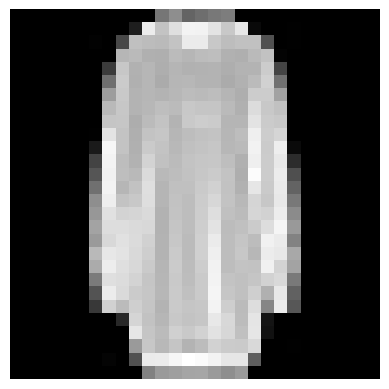

n=2 p=1 epsilon=0.3 distance_type='euclidean'
RV=np.float32(0.026529213)
prob_bound=np.int32(0)
t=0 -> t=1: P{DMAX(2)<=(1+0.3)DMIN(2)}>=0.0000%
n=2 p=1 epsilon=0.3 distance_type='euclidean'
RV=np.float32(0.002521184)
prob_bound=np.float64(0.7255809656340142)
t=0 -> t=-1: P{DMAX(2)<=(1+0.3)DMIN(2)}>=72.5581%


In [24]:
Q_point = path_list[0][888]
plot_data_point(Q_point.squeeze())

prob_bound = cod_prob_bound(
    path_list[1],
    EPSILON,
    Q_point,
    "euclidean",
    N,
)
print(f"t=0 -> t=1: P{{DMAX({N})<=(1+{EPSILON})DMIN({N})}}>={prob_bound:.4%}")


prob_bound = cod_prob_bound(
    path_list[-1],
    EPSILON,
    Q_point,
    "euclidean",
    N,
)
print(f"t=0 -> t=-1: P{{DMAX({N})<=(1+{EPSILON})DMIN({N})}}>={prob_bound:.4%}")

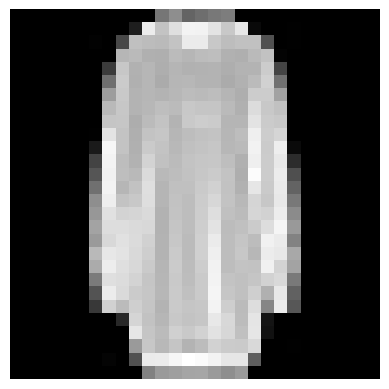

n=2 r=1000 p=1 epsilon=0.3 distance_type='euclidean'
RV=np.float32(0.025740132)
prob_bound=np.int32(0)
t=0 -> t=1: P{DMAX(2)<=(1+0.3)DMIN(2)}>=0.0000%
n=2 r=1000 p=1 epsilon=0.3 distance_type='euclidean'
RV=np.float32(0.0027515618)
prob_bound=np.float64(0.7010201703189608)
t=0 -> t=-1: P{DMAX(2)<=(1+0.3)DMIN(2)}>=70.1020%


In [26]:
Q_point = path_list[0][888]
plot_data_point(Q_point.squeeze())

estimate_prob_bound = estimate_cod_prob_bound(
    path_list[1],
    EPSILON,
    R,
    Q_point,
    "euclidean",
    N,
)
print(f"t=0 -> t=1: P{{DMAX({N})<=(1+{EPSILON})DMIN({N})}}>={estimate_prob_bound:.4%}")


estimate_prob_bound = estimate_cod_prob_bound(
    path_list[-1],
    EPSILON,
    R,
    Q_point,
    "euclidean",
    N,
)
print(f"t=0 -> t=-1: P{{DMAX({N})<=(1+{EPSILON})DMIN({N})}}>={estimate_prob_bound:.4%}")